# Question 2: 

### *Does the salesperson impact number and/or value of a sale? If so, can this be correlated to the reporting structure within the company?*

## Define Hypotheses

For this, we first need to define our hypotheses:
<br>
<br>
    ***Null Hypothesis:*** It makes no difference which employee took the order.
<br>
    ***Alternate Hypothesis:*** Certain employees generate more (or higher value) sales than others.


For reference, the relational structure of this dataset is provided below.
<img src='Northwind_ERD.png'>

## Importing Data & Libraries

In [1]:
# For SQL & dataframes
import pandas as pd
import sqlite3

# For math & statistics
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# For graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


### Make some dataframes

First, let's examine the basic aggregate sales stats for each employee.

In [12]:
c.execute("""
          SELECT o.EmployeeId, e.LastName, e.FirstName, e.Title, e.ReportsTo,
          AVG(OrderQuantity) as AvgQuantity, AVG(OrderPrice) as AvgPrice,
          COUNT(Distinct OrderId) as TotalOrders, SUM(OrderQuantity) as TotalQuantity, 
          SUM(OrderPrice) as TotalPrice
          FROM 'Order' o
          JOIN Employee e 
          ON o.EmployeeId = e.Id
          JOIN (SELECT OrderId, SUM(Quantity) as OrderQuantity, 
                SUM(Quantity*UnitPrice) as OrderPrice 
                FROM OrderDetail GROUP BY OrderId) od
          ON od.OrderId = o.Id
          GROUP BY o.EmployeeId
          ORDER BY AvgPrice desc;
          """)
employee_agg_sales_df = pd.DataFrame(c.fetchall())
employee_agg_sales_df.columns = [x[0] for x in c.description]
employee_agg_sales_df

,EmployeeId,LastName,FirstName,Title,ReportsTo,AvgQuantity,AvgPrice,TotalOrders,TotalQuantity,TotalPrice
0,7,King,Robert,Sales Representative,5.0,64.638889,1962.444306,72,4654,141295.99
1,9,Dodsworth,Anne,Sales Representative,5.0,62.093023,1929.395349,43,2670,82964.00
2,2,Fuller,Andrew,"Vice President, Sales",NaN,63.072917,1851.554792,96,6055,177749.26
3,5,Buchanan,Steven,Sales Manager,2.0,72.285714,1799.232143,42,3036,75567.75
4,3,Leverling,Janet,Sales Representative,2.0,61.826772,1677.569291,127,7852,213051.30
5,1,Davolio,Nancy,Sales Representative,2.0,63.512195,1643.444797,123,7812,202143.71
6,4,Peacock,Margaret,Sales Representative,2.0,62.807692,1603.765705,156,9798,250187.45
7,8,Callahan,Laura,Inside Sales Coordinator,2.0,56.855769,1281.740673,104,5913,133301.03
8,6,Suyama,Michael,Sales Representative,5.0,52.641791,1167.135821,67,3527,78198.10


It appears that every employee has made more than 30 sales, which is great for conducting statistical tests. 

Now let's make create a DataFrame that will serve as our sample population. Once we have this, we can take samples based on employee or reporting structure (second half).

In [4]:
c.execute("""
          SELECT o.EmployeeId, e.LastName, e.FirstName, e.Title, e.ReportsTo, od.OrderId, od.OrderQuantity, od.OrderPrice
          FROM 'Order' o
          JOIN Employee e 
          ON o.EmployeeId = e.Id
          JOIN (SELECT OrderId, SUM(Quantity) as OrderQuantity, 
                SUM(Quantity*UnitPrice) as OrderPrice 
                FROM OrderDetail GROUP BY OrderId) od
          ON od.OrderId = o.Id
          ORDER BY o.EmployeeId asc, od.OrderId asc;
          """)
employee_sales_df = pd.DataFrame(c.fetchall())
employee_sales_df.columns = [x[0] for x in c.description]
display(employee_sales_df.head())
employee_sales_df.info()

,EmployeeId,LastName,FirstName,Title,ReportsTo,OrderId,OrderQuantity,OrderPrice
0,1,Davolio,Nancy,Sales Representative,2.0,10258,121,2018.6
1,1,Davolio,Nancy,Sales Representative,2.0,10270,55,1376.0
2,1,Davolio,Nancy,Sales Representative,2.0,10275,18,307.2
3,1,Davolio,Nancy,Sales Representative,2.0,10285,121,2179.2
4,1,Davolio,Nancy,Sales Representative,2.0,10292,20,1296.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 8 columns):
EmployeeId       830 non-null int64
LastName         830 non-null object
FirstName        830 non-null object
Title            830 non-null object
ReportsTo        734 non-null float64
OrderId          830 non-null int64
OrderQuantity    830 non-null int64
OrderPrice       830 non-null float64
dtypes: float64(2), int64(3), object(3)
memory usage: 52.0+ KB


Let's take a look at the distribution of Order Prices.

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


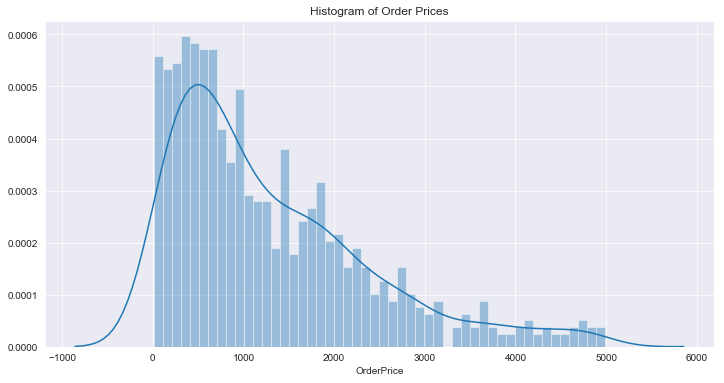

In [5]:
plt.figure(figsize=(12,6))
plt.title('Histogram of Order Prices')
plt.xlabel('Order Price in USD')

# This was run a previous time without the '<5000' portion to identify outliers. 
# Once outliers were identified, the '<5000' was chosen as a cutoff to remove the
# most extreme outliers.
sns.distplot(employee_sales_df.OrderPrice[employee_sales_df.OrderPrice<5000], bins=50);

Out of curiosity, let's break this down by individual employees.

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


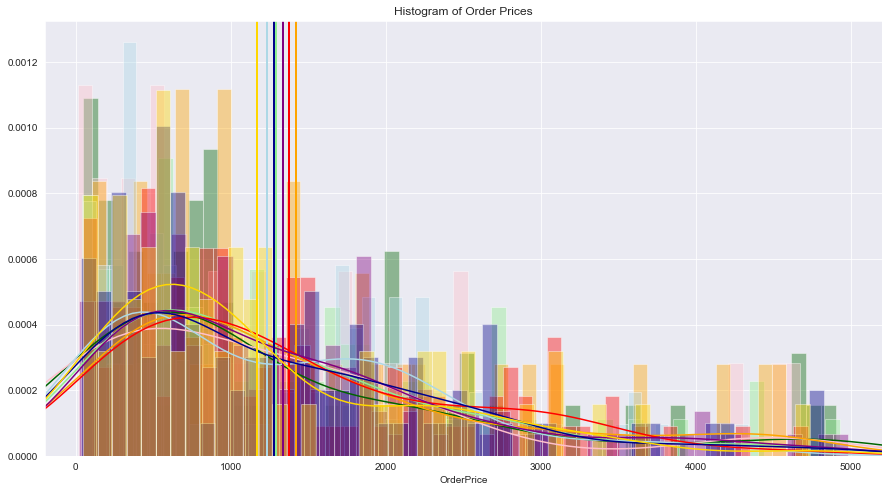

In [6]:
plt.figure(figsize=(15,8))
plt.xlim(-200, 5200)
plt.title('Histogram of Order Prices')
plt.xlabel('Order Price in USD')
colors = ['k','red','lightgreen','lightblue','purple','orange','gold','darkgreen','darkblue','pink']
for employee in list(employee_agg_sales_df.EmployeeId.values):
    sns.distplot(employee_sales_df.OrderPrice[(employee_sales_df.OrderPrice < 5000) & 
                                              (employee_sales_df.EmployeeId == employee)], bins=50, color=colors[employee])
    mu = np.mean(list(employee_sales_df.OrderPrice[(employee_sales_df.OrderPrice < 5000) & 
                                              (employee_sales_df.EmployeeId == employee)]))
    plt.axvline(mu, linewidth=2, color=colors[employee])
plt.show();

This is nearly impossible to read as it is a cluttered mess, but it does illustrate that the distributions for each employee are similar in general and all of the means are found in the $1200-1500 range.

To continue, we will need to define a few functions first.

In [7]:
def create_sample_distribution(data, dist_size=1000, n=30):
    """
    Inputs:
    - data : original dataset
    - dist_size : number of samples to generate
    - n : size of each sample
    =======================
    Returns:
    - sample distribution of sample means
    """
    sample_distr = []
    for i in range(0,dist_size):
        sample = []
        i_list = list(np.random.randint(0,len(data),n))
        for item in i_list:
            sample.append(data[item])
        sample_distr.append(np.mean(sample))
    return sample_distr


def welch_t(a, b):
    """ Calculate Welch's t statistic for two samples. """
    numerator = np.mean(a) - np.mean(b)
    denominator = np.sqrt(np.var(a, ddof=1)/len(a) + np.var(b, ddof=1)/np.size(b))
    return abs(numerator/denominator)


def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    num = (np.var(a, ddof=1)/np.size(a) + np.var(b, ddof=1)/np.size(b))**2
    denom = ((np.var(a, ddof=1)**2) / (((np.size(a))**2) * (np.size(a)-1))) + ((np.var(b, ddof=1)**2) / (((np.size(b))**2) * (np.size(b)-1)))
    return num/denom


def p_value(a, b, two_sided=False):
    """
    Returns the p-value from a Welch's t-test given two datasets (lists, arrays, or series).
    """
    t = welch_t(a,b)
    df = welch_df(a,b)
    p = 1 - stats.t.cdf(t, df)
    if two_sided:
        p += p
    return p

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


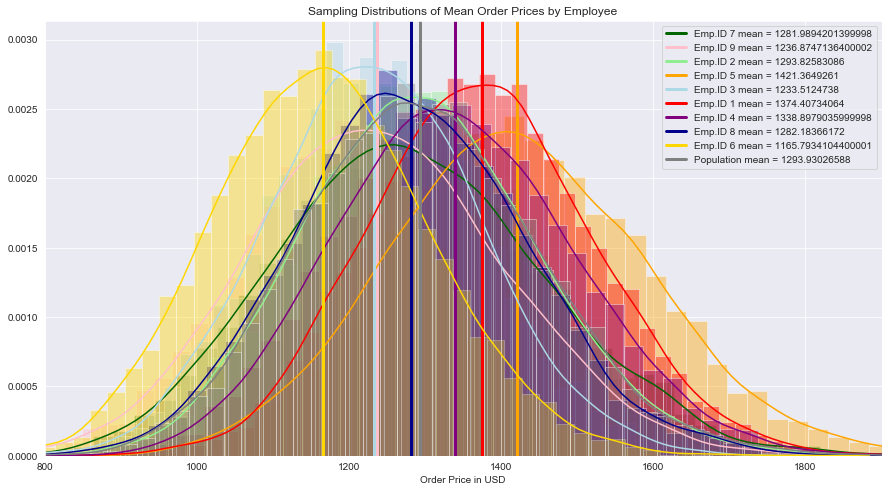

In [8]:
# Plot the sampling distributions for every employee
plt.figure(figsize=(15,8))
plt.xlim(800, 1900)
plt.title('Sampling Distributions of Mean Order Prices by Employee')
plt.xlabel('Order Price in USD')
colors = ['k','red','lightgreen','lightblue','purple','orange','gold','darkgreen','darkblue','pink']

emp = []
ord_pr = []
ordp = []
for employee in list(employee_agg_sales_df.EmployeeId.values):
    for i in range(0,10000):
        emp.append(employee)
    a1 = list(employee_sales_df.OrderPrice[(employee_sales_df.OrderPrice < 5000) & 
                                           (employee_sales_df.EmployeeId == employee)].values)
    a2 = create_sample_distribution(a1, 10000, 50)
    ordp.append(a2)
    sns.distplot(a2, bins=50, color=colors[employee])
    mu = np.mean(a2)
    plt.axvline(mu, linewidth=3, color=colors[employee], label=f'Emp.ID {employee} mean = {mu}')

for i in ordp:
    for e in i:
        ord_pr.append(e)
c1 = list(employee_sales_df.OrderPrice[employee_sales_df.OrderPrice < 5000].values)
c2 = create_sample_distribution(c1, 10000, 50)
sns.distplot(c2, bins=50, color='grey')
c_mu = np.mean(c2)
plt.axvline(c_mu, linewidth=3, color='grey', label=f'Population mean = {c_mu}')

plt.legend()
plt.show();

In [9]:
# Making a DataFrame of all of our sampling distributions
samp_distributions = {}
samp_distributions['EmpId'] = emp
samp_distributions['Ord_Pr'] = ord_pr
samp_distributions_df = pd.DataFrame(samp_distributions)

In [10]:
# Running an ANOVA test to see how influential choice of salesperson is
formula = 'Ord_Pr ~ C(EmpId)'
lm = ols(formula, samp_distributions_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq       df           F  PR(>F)
C(EmpId)  4.831318e+08      8.0  2470.59653     0.0
Residual  2.199748e+09  89991.0         NaN     NaN


Interesting, with a p-value of 0.0 from the ANOVA test, we can confidently reject the null hypothesis that the choice of salesperson does not impact the mean price of an order at almost any confidence level (well above the 99.99% threshold). 

### *Can this be correlated to the reporting structure within the company?*

Now that we know that it matters who the salesperson is, let's see if it makes a difference who the salesperson reports to. For this scenario, we are essentially dividing the employees into two teams. 

-One reports to (and includes) the VP -- EmployeeId [2, 6, 7, 9]

-The other reports to (and includes) the sales manager -- EmployeeId [1, 3, 4, 5, 8]